In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from post_motif_analysis.network_utils import draw_sub_graph, draw_neighbors, node_properties
from networks.loaders.network_loader import NetworkLoader
from utils.types import NetworkInputType, NetworkLoaderArgs
from networks.network import Network
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from typing import Any

simple_input_args = NetworkLoaderArgs(
    synapse_threshold=1,
    filter_polarity=['+', '-', 'complex'],
    filter_prim_nt=['GABA', 'Glu', 'ACh', 0],
    filter_syn_type='chem',
    filter_sex_type='herm'
)
loader = NetworkLoader(simple_input_args)

#network = loader.load_network_file(file_path="networks/data/polarity_2020/s1_data.xlsx",
#                                    input_type=NetworkInputType.polarity_xlsx)

network = loader.load_network_file(file_path="networks/data/Cook_2019/SI 2 Synapse adjacency matrices.xlsx",
                                    input_type=NetworkInputType.worm_wiring_xlsx)


#network = loader.load_network_file(file_path="networks/data/Cook_2019/SI 5 Connectome adjacency matrices, corrected July 2020.xlsx",
#                                    input_type=NetworkInputType.worm_wiring_xlsx)



Filtering Neurons of: herm
Filtering Synapses of type: chem
Network file name: SI 2 Synapse adjacency matrices.xlsx

Network properties:
	Neurons in the network: 272
	Participating Neurons (in the graph): 250

	Participating Nodes are neurons with at least: 1 synapses
	Synapses in the network: 9580
	Synapses in the graph: 9580
	Gaps in the network: 0
	Gaps in the graph: 0
	Nodes: 250
	Edges: 2982
	Average clustering coefficient: 0.25
	Average shortest path (undirected): 2.33
	Density: 0.048
	Degree: Mean: 23.856 Std: 15.698 Median: 20.0 Max: 97 (node: AVAL)
	In-Degree: Mean: 11.928 Std: 9.299 Median: 10.0 Max: 61 (node: AVAL)
	Out-Degree: Mean: 11.928 Std: 8.247 Median: 11.0 Max: 43 (node: DVA)


In [3]:
def basic_plot(data: Any, title: str, xlabel: str, ylabel: str, plot_func: Any, log_scale=False):
    plt.figure()

    if log_scale:
        plt.yscale("log")
        plt.xscale("log")

    plot_func(*data)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

In [4]:
def plot_rich_club_coefficient(network: Network):
    un_dir_graph = nx.Graph(network.graph)
    un_dir_graph.remove_edges_from(nx.selfloop_edges(un_dir_graph))
    rc = nx.rich_club_coefficient(un_dir_graph, normalized=False, seed=42)
    data = list(rc.keys()), list(rc.values())
    basic_plot(data=data,
               title='Rich Club Coefficient',
               xlabel='Degree (k)',
               ylabel='Rich Club Coefficient',
               plot_func=plt.scatter)


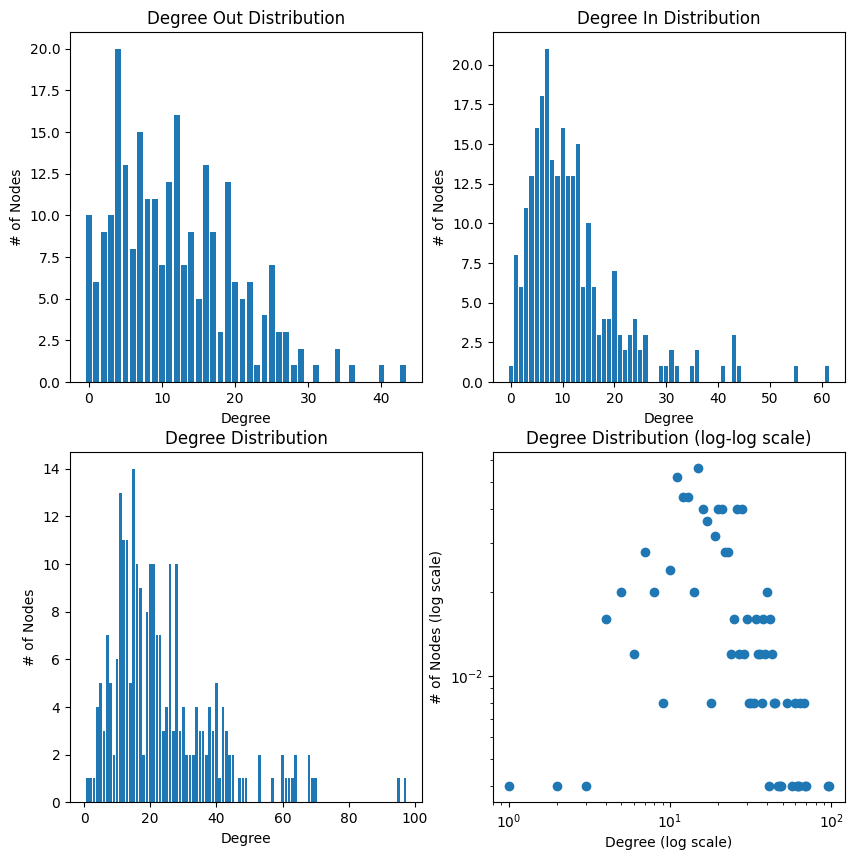

In [5]:
def _set_bar_subplot(ax, data, title, xlabel, ylabel):
    ax.bar(*data)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_degree_dist(network: Network):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    degree_sequence = sorted((d for n, d in network.graph.out_degree), reverse=True)
    data = np.unique(degree_sequence, return_counts=True)
    _set_bar_subplot(ax[0,0], data, 'Degree Out Distribution', 'Degree', '# of Nodes')

    degree_sequence = sorted((d for n, d in network.graph.in_degree), reverse=True)
    data = np.unique(degree_sequence, return_counts=True)
    _set_bar_subplot(ax[0,1], data, 'Degree In Distribution', 'Degree', '# of Nodes')

    degree_sequence = sorted((d for n, d in network.graph.degree()), reverse=True)
    data = np.unique(degree_sequence, return_counts=True)
    _set_bar_subplot(ax[1,0], data, 'Degree Distribution', 'Degree', '# of Nodes')

    # Log-Log
    y = nx.degree_histogram(network.graph)
    x = np.arange(0, len(y)).tolist()
    n = network.graph.number_of_nodes()

    for i in range(len(y)):
        y[i] = y[i] / n
    
    ax[1,1].plot(x, y, 'o')
    ax[1,1].set_xscale('log')
    ax[1,1].set_xlabel('Degree (log scale)')
    ax[1,1].set_yscale('log')
    ax[1,1].set_ylabel('# of Nodes (log scale)')
    ax[1,1].set_title('Degree Distribution (log-log scale)')


plot_degree_dist(network)

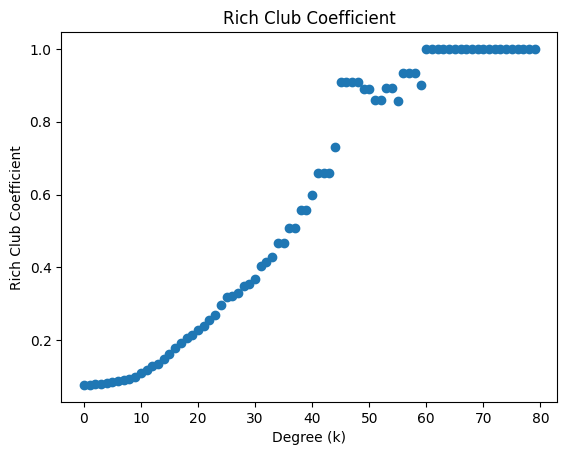

In [6]:
plot_rich_club_coefficient(network)

['PDEL', 'PDER', 'LUAL', 'LUAR', 'RIGL', 'SAAVR', 'AVDL', 'AVDR', 'AVEL', 'AVER', 'AVBL', 'AVBR', 'AVAL', 'PVCL', 'PVCR', 'SABVR', 'SMDVR', 'DA01', 'DA02', 'DA03', 'DA04', 'DA05', 'DA06', 'DA07', 'DA08', 'DA09', 'DB02', 'DB03', 'AS01', 'AS02', 'AS04', 'AS05', 'AS06', 'AS11', 'VA02', 'VA03', 'VA04', 'VA06', 'VA10', 'VA11']


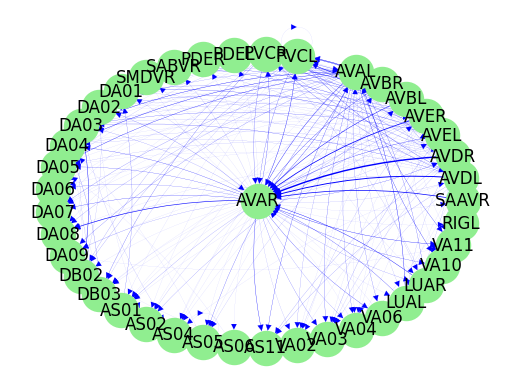

In [7]:
draw_neighbors(network, 'AVAR', 'out', True)

In [24]:
node_properties(network, 'AIAL')

Node AIAL properties:
Degree: 0


nerve ring

In [51]:
from random_networks.nerve_ring_markov_chain_switching import NerveRingMarkovChainSwitching
nerve_ring = NerveRingMarkovChainSwitching(network, switch_factor=10)

nerve_ring.DISTANCE_TH = 0.1
nerve_ring.init_nerve_ring_allow_list()
nerve_ring_allow = nerve_ring.nerve_ring_allow

In [52]:
ratios = []
for n in nerve_ring_allow:
    if n not in network.neuron_names:
        # print(n)
        continue
    node_idx = network.neuron_names.index(n)
    
    if node_idx not in dict(network.graph.degree):
        print(n)
        continue

    synapses = network.graph.degree[node_idx]
    pot_synapses = len(nerve_ring_allow[n])
    ratio = synapses / pot_synapses
    print(n, synapses, pot_synapses, round(ratio,2))
    ratios.append(ratio)

ADAR 32 129 0.25
ADAL 35 130 0.27
ADEL 42 100 0.42
ADER 36 98 0.37
ADFL 27 98 0.28
ADFR 38 118 0.32
ADLL 30 104 0.29
ADLR 42 114 0.37
AFDL 17 82 0.21
AFDR 13 99 0.13
AIAL
AIAR 28 117 0.24
AIBL 53 164 0.32
AIBR 57 162 0.35
AIML 24 97 0.25
AIMR 28 107 0.26
AINL 20 123 0.16
AINR 21 115 0.18
AIYL 23 110 0.21
AIYR 26 126 0.21
AIZL 39 130 0.3
AIZR 32 134 0.24
ALA 11 111 0.1
ALML 28 77 0.36
ALMR 11 88 0.12
ALNL 12 100 0.12
ALNR 14 103 0.14
AQR 28 171 0.16
ASEL 28 137 0.2
ASER 36 144 0.25
ASGL 9 50 0.18
ASGR 15 67 0.22
ASHL 25 112 0.22
ASHR 36 124 0.29
ASIL 21 72 0.29
ASIR 15 90 0.17
ASJL 11 85 0.13
ASJR 4 89 0.04
ASKL 11 89 0.12
ASKR 16 81 0.2
AUAL 20 97 0.21
AUAR 20 104 0.19
AVAL 97 169 0.57
AVAR 95 161 0.59
AVBL 64 172 0.37
AVBR 60 170 0.35
AVDL 60 165 0.36
AVDR 70 165 0.42
AVEL 68 164 0.41
AVER 68 161 0.42
AVFL 29 157 0.18
AVFR 27 154 0.18
AVHL 40 159 0.25
AVHR 34 154 0.22
AVJL 38 160 0.24
AVJR 43 161 0.27
AVKL 28 153 0.18
AVKR 28 156 0.18
AVL
AVM 22 127 0.17
AWAL 12 96 0.12
AWAR 23 116 0.

(array([ 8., 20., 38., 48., 26., 16., 14.,  2.,  0.,  2.]),
 array([0.03030303, 0.08627894, 0.14225485, 0.19823075, 0.25420666,
        0.31018257, 0.36615848, 0.42213439, 0.4781103 , 0.5340862 ,
        0.59006211]),
 <BarContainer object of 10 artists>)

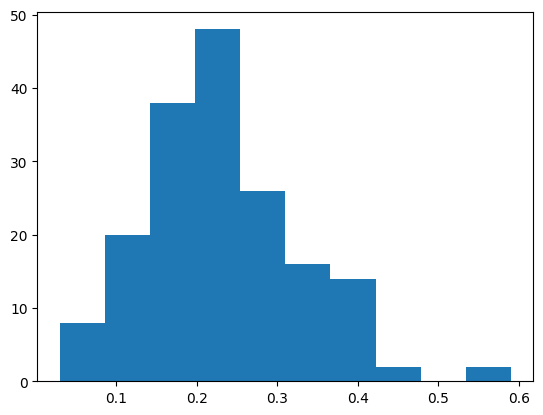

In [53]:
plt.hist(ratios)